Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, LinearAlgebra
#gr(size=(600,600));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type Chains, with data of type 1000×2×4 Array{Float64,3}

Iterations        = 1001:2000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = 
parameters        = sigma, mu

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64 │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼─────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ mu         │ 154.611 │ 0.401807 │ 0.00635313 │ 0.00543652 │ 4000.0  │
│ 2   │ sigma      │ 7.77226 │ 0.295875 │ 0.0046782  │ 0.0042213  │ 3901.14 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%   │ 50.0%   │ 75.0%   │ 97.5%   │
│     │ Symbol     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ mu         │ 153.827 │ 154.334 │ 154.609 │ 154.881 │ 155.399 │


Describe the draws

In [6]:
describe(chn)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64 │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼─────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ mu         │ 154.611 │ 0.401807 │ 0.00635313 │ 0.00543652 │ 4000.0  │
│ 2   │ sigma      │ 7.77226 │ 0.295875 │ 0.0046782  │ 0.0042213  │ 3901.14 │

Quantiles

│ Row │ parameters │ 2.5%    │ 25.0%   │ 50.0%   │ 75.0%   │ 97.5%   │
│     │ Symbol     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ mu         │ 153.827 │ 154.334 │ 154.609 │ 154.881 │ 155.399 │
│ 2   │ sigma      │ 7.22014 │ 7.56577 │ 7.76818 │ 7.96195 │ 8.36305 │


Plot the density of posterior draws

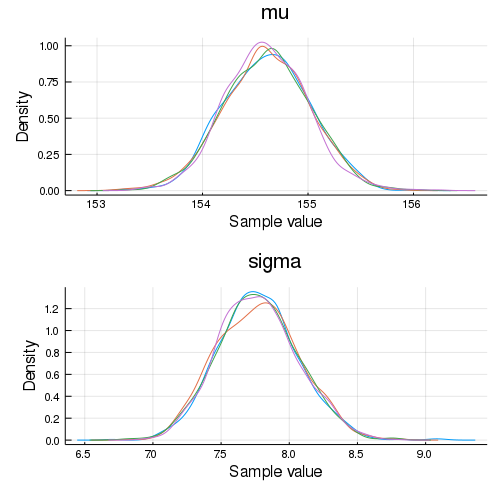

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.0868168769450246
 0.1627318682672672

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0         -0.00822332
 -0.00822332   1.0       

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*